In [1]:
#Prophet Daily

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [2]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'ds'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
df = df.set_index('ds')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
ds,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [3]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['ds'])['y'].sum()
data = pd.DataFrame(data)
print(data.head())
print(data.describe())

                     y
ds                    
2020-11-18  21891600.0
2020-11-25  27364500.0
2020-11-27  16123000.0
2020-11-28   7344400.0
2020-11-29  31336000.0
                  y
count  6.290000e+02
mean   5.551835e+07
std    6.434455e+07
min    7.994000e+03
25%    1.280100e+07
50%    3.407160e+07
75%    7.794424e+07
max    4.858937e+08


In [4]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):

n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
ds                     
2021-10-17  375372000.0
2021-10-24  287017000.0
2021-12-08  189834100.0
2022-01-12  262409500.0
2022-01-13  177271000.0
2022-01-16  184863000.0
2022-01-31  204342000.0
2022-02-16  182886300.0
2022-02-17  220170000.0
2022-02-28  213469000.0
2022-07-28  204959459.0
2022-09-17  192559703.0
2022-10-18  184679491.0
2022-11-03  250884985.0
2022-11-06  336473806.0
2022-11-20  326221966.0
2022-12-04  348875662.0
2022-12-07  305095300.0
2022-12-13  236500741.0
2022-12-18  354723498.0
2022-12-23  291265309.0
2023-01-02  281983243.0
2023-01-10  186120115.0
2023-01-16  266497112.0
2023-01-27  485893693.0
2023-01-30  313164440.0
2023-02-13  308880309.0
2023-02-27  222864584.0
2023-03-05  253894290.0
2023-03-07  326880253.0
2023-03-21  221348637.0
2023-03-23  225836091.0
Outliers ke- 2 :                        y
ds                     
2021-10-19  151220000.0
2021-11-05  175035000.0
2021-11-11  155209000.0
2021-11-24  154454900.0
2022

,y
ds,
2020-11-18,21891600.0
2020-11-25,27364500.0
2020-11-27,16123000.0
2020-11-28,7344400.0
2020-11-29,31336000.0
...,...
2023-03-26,6122998.0
2023-03-28,895757.0
2023-03-29,58286000.0


In [5]:
#INTERPOLASI

print(f"start date: {min(data.index)}, end date: {max(data.index)}")
data = data.asfreq('d')
data = data.interpolate(method='linear')
data = data.fillna(0)
data = data.astype({'y':'int'})
# data = data.astype({'y':'int'})
print(f'Number of rows with missing values: {data.isnull().mean()}')
data = data.reset_index().rename(columns={'index': 'ds'})
data

start date: 2020-11-18 00:00:00, end date: 2023-04-09 00:00:00
Number of rows with missing values: y    0.0
dtype: float64


,ds,y
0,2020-11-18,21891600
1,2020-11-19,22673442
2,2020-11-20,23455285
3,2020-11-21,24237128
4,2020-11-22,25018971
...,...,...
868,2023-04-05,16273000
869,2023-04-06,12582250
870,2023-04-07,8891500
871,2023-04-08,5200750


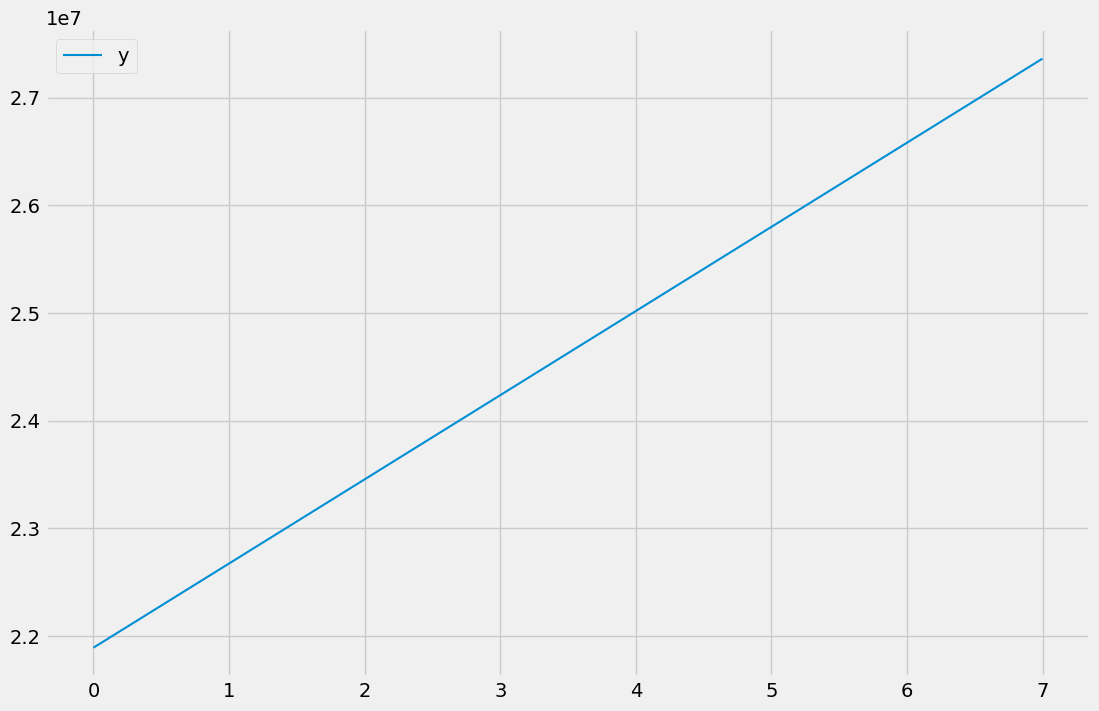

In [6]:
revenue_plot =data['y'].iloc[0:8].plot(
    figsize=(12,8),
    legend=True,
)

In [7]:
#Standar Scaler
#Standardize features by removing the mean and scaling to unit variance.

unscaled = data['y'].values.reshape(len(data['y']),1)
scaler = StandardScaler()
scaler.fit(unscaled)
scaled = scaler.transform(unscaled)
data['y'] = scaled
data['y']

0     -0.428437
1     -0.403998
2     -0.379558
3     -0.355119
4     -0.330680
         ...   
868   -0.604068
869   -0.719436
870   -0.834804
871   -0.950173
872   -1.065541
Name: y, Length: 873, dtype: float64

In [8]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
# inverse scale the predicted values
unscaled = data['y'].values.reshape(len(data['y']),1)
scaler = MinMaxScaler()
scaler.fit(unscaled)
scaled = scaler.transform(unscaled)
data['y'] = scaled
data['y']

0      0.167047
1      0.173015
2      0.178983
3      0.184951
4      0.190919
         ...   
868    0.124158
869    0.095984
870    0.067811
871    0.039638
872    0.011465
Name: y, Length: 873, dtype: float64

In [9]:
print(data.head())
print(data.describe())

          ds         y
0 2020-11-18  0.167047
1 2020-11-19  0.173015
2 2020-11-20  0.178983
3 2020-11-21  0.184951
4 2020-11-22  0.190919
                        ds           y
count                  873  873.000000
mean   2022-01-28 00:00:00    0.271671
min    2020-11-18 00:00:00    0.000000
25%    2021-06-24 00:00:00    0.080517
50%    2022-01-28 00:00:00    0.190667
75%    2022-09-03 00:00:00    0.391926
max    2023-04-09 00:00:00    1.000000
std                    NaN    0.244341


In [10]:
#PLOT DATA TRAIN & DATA TEST
train_size = int(len(data) * 0.8)
steps = 28
data_train = data[:-steps]
data_test  = data[-steps:]


In [11]:
# Initialize and fit Prophet model
model = Prophet()
model.fit(data_train)

08:24:46 - cmdstanpy - INFO - Chain [1] start processing
08:24:47 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Create future dates to predict
future = model.make_future_dataframe(periods=len(data_test))

In [13]:
# Generate forecast
forecast = model.predict(future)

In [14]:
forecast.tail() #yhat itu prediksi nya

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
868,2023-04-05,0.303791,0.080318,0.640953,0.303558,0.304049,0.067915,0.067915,0.067915,0.053718,0.053718,0.053718,0.014197,0.014197,0.014197,0.0,0.0,0.0,0.371706
869,2023-04-06,0.303738,0.075424,0.638693,0.303483,0.304016,0.049545,0.049545,0.049545,0.034853,0.034853,0.034853,0.014692,0.014692,0.014692,0.0,0.0,0.0,0.353282
870,2023-04-07,0.303684,-0.020875,0.553429,0.303413,0.303984,-0.036706,-0.036706,-0.036706,-0.052016,-0.052016,-0.052016,0.015310,0.015310,0.015310,0.0,0.0,0.0,0.266979
871,2023-04-08,0.303631,-0.001508,0.560520,0.303347,0.303946,-0.021914,-0.021914,-0.021914,-0.037860,-0.037860,-0.037860,0.015946,0.015946,0.015946,0.0,0.0,0.0,0.281717
872,2023-04-09,0.303578,0.013672,0.597038,0.303278,0.303912,-0.010938,-0.010938,-0.010938,-0.027431,-0.027431,-0.027431,0.016493,0.016493,0.016493,0.0,0.0,0.0,0.292639


In [15]:
# plot the forecast
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model,forecast)

In [ ]:
prediction = forecast.iloc[-len(data_test):]['yhat']

In [18]:
from statsmodels.tools.eval_measures import rmse
print("Root Mean Squared Error between actual and  predicted values: ",rmse(prediction,data_test['y']))
print("Mean Value of Test Dataset:", data_test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  0.2540257628716369
Mean Value of Test Dataset: 0.2566379715558714
